In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None, label = "None", marker_size = 6):
    plt.grid(True)
    plt.plot(x, y, "o", markersize = marker_size)
    k, b = mnk_non_zero(x, y)
    if(xmin == None):
        xmin = DData(x.min()).value
    if(xmax == None):
        xmax = DData(x.max()).value
    xl = np.array([xmin, xmax])
    plt.plot(xl, xl*k.value + b.value, label = label)
    print("k, b =", k, b)
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
    else:
        y_value = y
        y_error = [0]*len(y_error)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x.min().value
    if(xmax == None):
        xmax = x.max().value
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



<>:201: SyntaxWarning: invalid escape sequence '\p'
<>:204: SyntaxWarning: invalid escape sequence '\p'
<>:206: SyntaxWarning: invalid escape sequence '\p'
<>:206: SyntaxWarning: invalid escape sequence '\c'
<>:209: SyntaxWarning: invalid escape sequence '\p'
<>:201: SyntaxWarning: invalid escape sequence '\p'
<>:204: SyntaxWarning: invalid escape sequence '\p'
<>:206: SyntaxWarning: invalid escape sequence '\p'
<>:206: SyntaxWarning: invalid escape sequence '\c'
<>:209: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_6856\3736872952.py:201: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_6856\3736872952.py:204: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_6856\3736872952.py:206: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10^{E

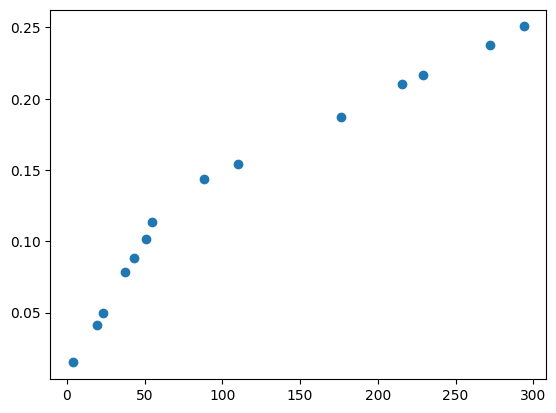

In [3]:
p_k = 1.96
l_1 = DData(500, 5, E = -3)
l_1.E = 0
D_1 = DData(5.1, 0.05, E=-3)
D_1.E = 0
data_1_1 = pd.read_csv("data_1_1.csv")
data_1_1["Q"] = data_1_1["Q0"]/60
data_1_1["P"] = data_1_1["P0"]*p_k
plt.plot(data_1_1["P"],data_1_1["Q"], "o")



k, b = $2.52 \pm 0.10$ $94.8 \pm 8.2$


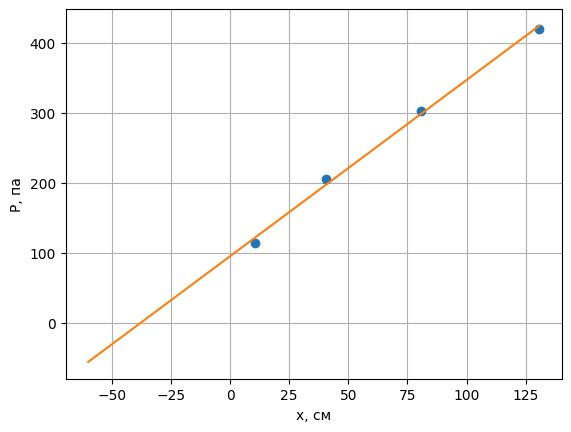

In [4]:
data_1_2 = pd.read_csv("data_1_2.csv")
data_1_2["P"] = data_1_2["P0"]*p_k

linearcalc(data_1_2["x"], data_1_2["P"], xmin=-60)
plt.xlabel("x, см")
plt.ylabel("P, па")
plt.savefig("graph_1_2.png", dpi=300)


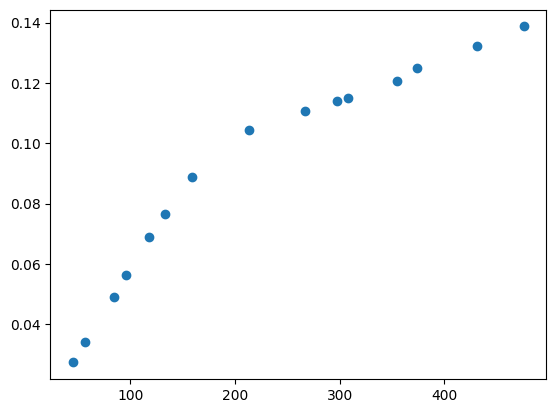

In [5]:
p_k = 1.96
l_2 = DData(500, 5, E = -3)
l_2.E = 0
D_2= DData(3.95, 0.05, E=-3)
D_2.E = 0
data_2_1 = pd.read_csv("data_2_1.csv")
data_2_1["Q"] = data_2_1["Q0"]/60
data_2_1["P"] = data_2_1["P0"]*p_k
plt.plot(data_2_1["P"],data_2_1["Q"], "o")

k, b = $3.46 \pm 0.23$ $60 \pm 17$


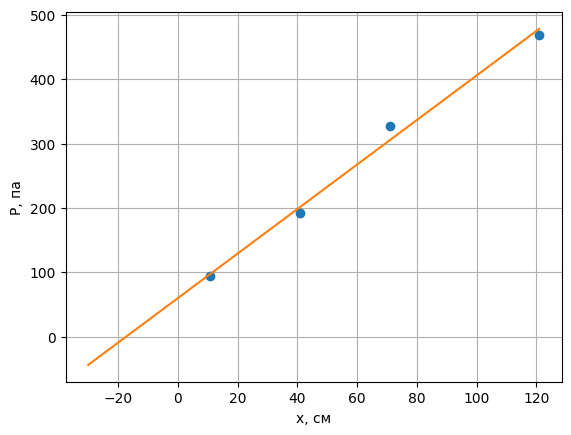

In [6]:
data_2_2 = pd.read_csv("data_2_2.csv")
data_2_2["P"] = data_2_2["P0"]*p_k
linearcalc(data_2_2["x"], data_2_2["P"], xmin=-30)
plt.xlabel("x, см")
plt.ylabel("P, па")
plt.savefig("graph_2_2.png", dpi=300)

k, b = $0.001923 \pm 0.000043$ $0.0056 \pm 0.0016$
$1.726 \pm 0.080$
k, b = $0.0005483 \pm 0.0000089$ $0.00317 \pm 0.00094$
$2.18 \pm 0.12$


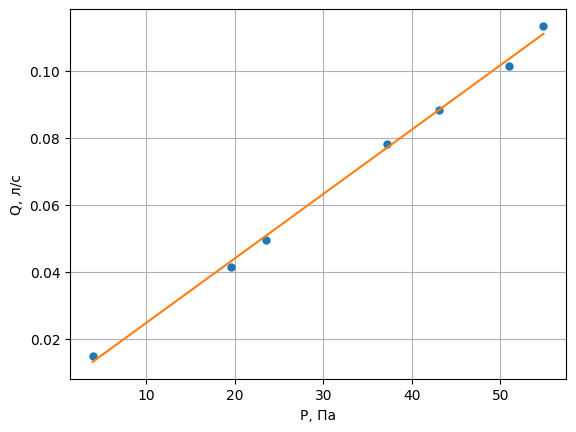

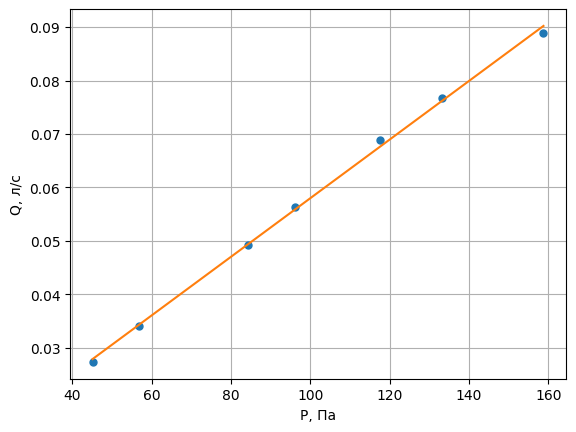

In [7]:
def calc(data,D,l,P_srez,name):
    plt.figure()
    R = D/2
    l = l_1
    srez = data[data["P"]<P_srez]
    plt.xlabel("P, Па")
    plt.ylabel("Q, л/с")
    k, _ = linearcalc(srez["P"], srez["Q"], marker_size=5)
    plt.savefig(name, dpi = 300)
    k *= 10**-3 
    eta = 3.14*R**4/8/l/k
    eta.E = -5
    print(eta)
    return eta

eta_1 = calc(data_1_1, D_1, l_1, 70, "graph_1_3.png")
eta_2 = calc(data_2_1, D_2, l_2, 190, "graph_2_3.png")


In [8]:
table = pd.DataFrame()
table["D, мм"] = [D_1, D_2]
table["L, мм"] = [l_1, l_2]
DData.changeEInSerias(table["D, мм"], -3)
DData.changeEInSerias(table["L, мм"], -3)
table["$\\eta$, $10^{-5} \\frac{кг}{м\\cdot с}$"] = [eta_1, eta_2]
table["$P_{кр}$, Па"] = [70, 190]
table["$Q_{кр}$, л/с"] = [0.13, 0.10]
table["$Re_{кр}$"] = 1.29*table["$Q_{кр}$, л/с"]/3.14*2/table["D, мм"]/table["$\\eta$, $10^{-5} \\frac{кг}{м\\cdot с}$"]/1000
DData.changeEInSerias(table["$Re_{кр}$"], 0)

l_ust_1 = 1.29*9.3/60000/3.14*2/D_1/1.7*100000 * 0.1 * D_1
l_ust_1 = 1.29*4.8/60000/3.14*2/1.7*100000 * 0.1
print(l_ust_1)


table.to_clipboard()
table

0.3866616710378419


,"D, мм","L, мм","$\eta$, $10^{-5} \frac{кг}{м\cdot с}$","$P_{кр}$, Па","$Q_{кр}$, л/с",$Re_{кр}$
0,$5.100 \pm 0.050$,$500.0 \pm 5.0$,$1.726 \pm 0.080$,70,0.13,$1213 \pm 57$
1,$3.950 \pm 0.050$,$500.0 \pm 5.0$,$2.18 \pm 0.12$,190,0.10,$955 \pm 53$


In [22]:
data_10 = pd.DataFrame()
data_10["l"] = [130.5, 46, 130.5, 46]
data_10["p0"] = [107,38,222,78]
data_10["p"] = data_10["p0"]*9.81
data_10["p/l"] = data_10["p"]/data_10["l"]
data_10["Q"] = [0.114, 0.041, 0.2869, 0.1340]
xs = [1.95, 2.60]
ys_1 = [data_10["Q"][0], data_10["Q"][2]]
ys_2 = [data_10["Q"][1], data_10["Q"][3]]
data_10
x_log, y_log_1, y_log_2 = np.log(xs), np.log(ys_1), np.log(ys_2)
n1 = (y_log_1[1]-y_log_1[0])/(x_log[1]-x_log[0])
n2 = (y_log_2[1]-y_log_2[0])/(x_log[1]-x_log[0])
print(n1, n2)
data_10

3.2081779261636787 4.116585100884595


,l,p0,p,p/l,Q
0,130.5,107,1049.67,8.043448,0.1140
1,46.0,38,372.78,8.103913,0.0410
2,130.5,222,2177.82,16.688276,0.2869
3,46.0,78,765.18,16.634348,0.1340
